Nous avons notre fonction de feature obtenue dans la première partie

In [6]:
def input_output_validation(data):
    
    Name = data.Name.str.split(",", expand = True )
    Name.columns = ["Country", "Name"]
    data["civility"] = Name.Name.str.split(".",expand = True)[0]
    
    #data['Survived'] = data['Survived'].astype('object')
    #Utiliser la classe et la civilité pour remplir l'age
    data['Age'] = data.groupby(['Pclass', 'civility'])['Age'].transform(lambda x: x.fillna(x.mean()))
    data['Age_levels'] = pd.cut(data['Age'], bins=[0,10,25,50,100])
    data['Age_levels'].value_counts()
    data['Age_levels'] = data['Age_levels'].astype('object')
    

    
    data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])
    data["Country"]= Name.Country
    data = data [['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','civility','Age_levels']]
    return data

In [7]:
# Chargement de la table
#, encoding = 'cp1252', error_bad_lines=False,
import numpy as np
from pandera import Column, DataFrameSchema, Check, check_io
import pandas as pd 
import pandera as pa


df = pd.read_csv(r'ChanDarren_RaiTaran_Lab2a.csv', delimiter =",")
df.head(2)

c:\Users\DPCS6481\Documents\Projet Postgresql\env_projet\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


Nous allons spliter nos données à la base pour éviter le linkeage. En effet, nos données de tests doivent être aveugles par rapport à nos données de train

In [8]:
from sklearn.model_selection import train_test_split 

target = df.Survived
variable = df.drop(columns = ['Survived'])

X_train, X_test, y_train, y_test = train_test_split(
variable, target, test_size=0.2, random_state=42)


X_train = input_output_validation(X_train)
X_test = input_output_validation(X_test)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,civility,Age_levels
331,1,male,45.5,0,0,28.5000,S,Mr,"(25, 50]"
733,2,male,23.0,0,0,13.0000,S,Mr,"(10, 25]"
382,3,male,32.0,0,0,7.9250,S,Mr,"(25, 50]"
704,3,male,26.0,1,0,7.8542,S,Mr,"(25, 50]"
813,3,female,6.0,4,2,31.2750,S,Miss,"(0, 10]"


Ramenons les données  au format de notre feature engineering et créons notre pipeline

In [9]:


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn import set_config



#Selectionner les variables catégorielles et numériques pour une pipeline
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)


#Choix de la méthode de traitement des variables
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])



model = make_pipeline(preprocessor, LogisticRegression())


Visualisons notre première pipeline

In [10]:
set_config(display='diagram')
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Embarked',
                                                   'civility', 'Age_levels']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare'])])),
                ('logisticregression', LogisticRegression())])

In [11]:
# solution
cv = ShuffleSplit(random_state=0)
SVC_ = make_pipeline(preprocessor, SVC())
# %%
SVC_score= cross_validate(SVC_, X_train, y_train, cv=cv, n_jobs=2)
SVC_score = pd.DataFrame(SVC_score)
print(
    f"Support Vector classifier: "
      f"{SVC_score['test_score'].mean():.3f} ± "
      f"{SVC_score['test_score'].std():.3f}")

Support Vector classifier: 0.840 ± 0.044


In [12]:
from sklearn.ensemble import RandomForestClassifier

random_forest = make_pipeline(preprocessor, RandomForestClassifier(random_state = 42))
# %%
scores_random_forest = cross_validate(random_forest, X_train, y_train, cv=cv, n_jobs=2)
scores_random_forest = pd.DataFrame(scores_random_forest)
print(
    f"Random forest classifier: "
      f"{scores_random_forest['test_score'].mean():.3f} ± "
      f"{scores_random_forest['test_score'].std():.3f}")

Random forest classifier: 0.787 ± 0.033


Nous allons faire de l'hyperparamétrage : Nous pouvons déja voir les variables sur lesquelles nous pouvons jouer

In [13]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [14]:
from sklearn.model_selection import GridSearchCV
import numpy as np
param_grid = {
    'randomforestclassifier__n_estimators': (10,100,200),
    'randomforestclassifier__max_leaf_nodes': np.arange(3,10,30),
    'randomforestclassifier__max_features':[1,3,5,7],
    'randomforestclassifier__max_depth' : [3,5,10,None],
    'randomforestclassifier__max_samples': (3, 10)  
}
rand_auc = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring='accuracy', cv=5, verbose=False)
rand_auc.fit(X_train, y_train)
accuracy = rand_auc.score(X_train, y_train)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)
print(f"The best set of parameters is: "
      f"{rand_auc.best_params_}")

The test accuracy score of the grid-searched pipeline is: 0.79
The best set of parameters is: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 7, 'randomforestclassifier__max_leaf_nodes': 3, 'randomforestclassifier__max_samples': 10, 'randomforestclassifier__n_estimators': 200}


In [15]:
from sklearn.model_selection import GridSearchCV
import numpy as np
param_grid = {'svc__C': [0,1,10,100,1000],
    #'svc__gamma': [1,0.1,0.01, 0.001,0.0001],
        #'svc__kernel':['rbf']
             }
rand_auc = GridSearchCV(estimator=SVC_, param_grid=param_grid, scoring='accuracy', cv=5, verbose=False)
rand_auc.fit(X_train, y_train)
accuracy = rand_auc.score(X_train, y_train)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)
print(f"The best set of parameters is: "
      f"{rand_auc.best_params_}")

The test accuracy score of the grid-searched pipeline is: 0.85
The best set of parameters is: {'svc__C': 1}


c:\Users\DPCS6481\Documents\Projet Postgresql\env_projet\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DPCS6481\Documents\Projet Postgresql\env_projet\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DPCS6481\Documents\Projet Postgresql\env_projet\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\DPCS6481\Documents\Projet Postgresql\env_projet\lib\site-p

In [16]:
# Fit the ColumnTransformer to your training data
preprocessor.fit(X_train)

# Transform your training data
X_train_transformed = preprocessor.transform(X_train)

# Now you can access the feature names
feature_names = preprocessor.get_feature_names_out()

C:\Users\DPCS6481\AppData\Local\Temp\ipykernel_24184\148956356.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names, rotation=90, fontsize=12)


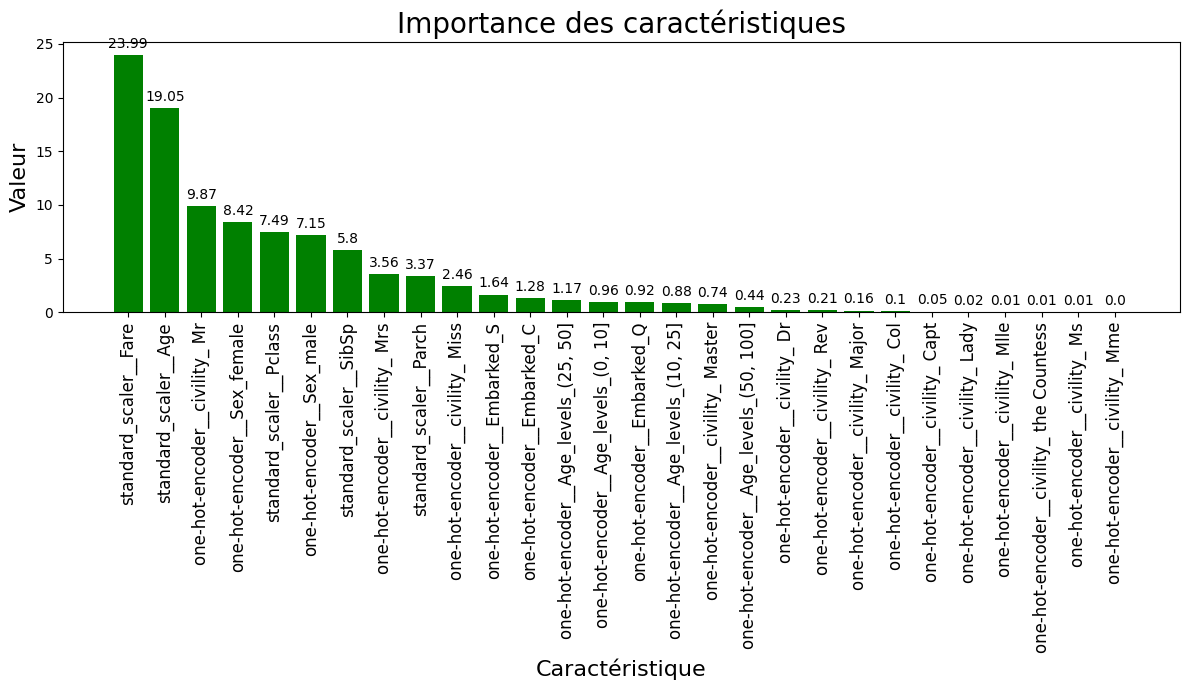

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
feature_names = list(feature_names)
_ = random_forest.fit(X_train, y_train)
coefs = random_forest.named_steps['randomforestclassifier'].feature_importances_*100
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

import matplotlib.pyplot as plt

# Extraction des données
feature_names = df["feature"]
coefs = df["value"]
colors = df["colors"]

# Création du graphique
fig, ax = plt.subplots(figsize=(12, 7))

# Tracé des barres
bars = ax.bar(feature_names, coefs, color=colors)
# Ajout des étiquettes aux barres
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(round(height, 2)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Configuration de l'axe des x
ax.set_xticklabels(feature_names, rotation=90, fontsize=12)

# Titre et étiquettes des axes
ax.set_title("Importance des caractéristiques", fontsize=20)
ax.set_ylabel("Valeur", fontsize=16)
ax.set_xlabel("Caractéristique", fontsize=16)

# Affichage du graphique
plt.tight_layout()
plt.show()

In [ ]:
import joblib
from sklearn.metrics import accuracy_score

random_forest.fit(X_train, y_train)
precision_test = accuracy_score(y_test,random_forest.predict(X_test))
precision_train = accuracy_score(y_test,random_forest.predict(X_test))

if precision_test > 0.75 and abs(precision_train - precision_test) < 0.15 :
# Sauvegarde du modèle dans un fichier
    joblib.dump(random_forest, 'random_forest_model.joblib')

    print("Model saved successfully!")
else :
    print("Revoyez le modèle")

Model saved successfully!
